In [208]:
# imports
import utils.rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [209]:
# User Variables

ROSBAGS_DIR = "/home/bjm255/couguv/cougars/bag" + '/DFB_Oceans_Paper' 
# ROSBAGS_DIR = "/home/bjm255/couguv/cougars/bag" + '/sim' 
SAVES_DIR = "DFB_Oceans_Paper"

MISSION_KEYWORDS = ["30.0"]
start_crop = 0
end_crop = -1

sim_crop = 0
end_crop_sim = -1

VERBOSE=True

In [210]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__30.0_bl_dfs_20250723_183705
Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__sim_30.0_dfs_20250729_233600
Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__sim_30.0_20250730_004521
Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__sim_30.0_1100_speed_20250729_234203


In [211]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__30.0_bl_dfs_20250723_183705:
	['/desired_speed', '/modem_imu', '/kinematics/command', '/controls/command', '/leak/data', '/modem_status', '/controls/debug', '/battery/data', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']
converted__sim_30.0_dfs_20250729_233600:
	['/desired_speed', '/controls/command', '/controls/debug', '/desired_heading', '/diagnostics', '/desired_depth']
converted__sim_30.0_20250730_004521:
	['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']
converted__sim_30.0_1100_speed_20250729_234203:
	['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']


In [212]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
# dfsByTopic = {}

# for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
# print(list(dfsByTopic.keys()))

In [213]:
# Get only the first dataframe
rw_data, rw_topics = list(dataframes.items())[0]


# Get the second dataframe
sim_data, sim_topics = list(dataframes.items())[2]

print(f"{sim_data}:\n\t{list(sim_topics.keys())}")
print(f"{rw_data}:\n\t{list(rw_topics.keys())}")

converted__sim_30.0_20250730_004521:
	['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']
converted__30.0_bl_dfs_20250723_183705:
	['/desired_speed', '/modem_imu', '/kinematics/command', '/controls/command', '/leak/data', '/modem_status', '/controls/debug', '/battery/data', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']


In [214]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = rw_topics["/controls/debug"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec  header.frame_id  depth.actual  \
0        1753317425             669046202              NaN     -0.006329   
1        1753317425             749002384              NaN     -0.006227   
2        1753317425             829023399              NaN     -0.006022   
3        1753317425             909008711              NaN     -0.006431   
4        1753317425             989023207              NaN     -0.006227   

   depth.rate  depth.desired  depth.reference   depth.p  depth.i  depth.d  \
0         0.0            0.0              0.0  0.126577      0.0      0.0   
1         0.0            0.0              0.0  0.124533      0.0      0.0   
2         0.0            0.0              0.0  0.120443      0.0      0.0   
3         0.0            0.0              0.0  0.128622      0.0      0.0   
4         0.0            0.0              0.0  0.124533      0.0      0.0   

   ...   pitch.d  pitch.pid  heading.actual  heading.rate  he

In [215]:
# convert ros timestamps to pandas timestamps

for df in sim_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

sim_timestamps = sim_topics["/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{sim_timestamps.min()} --- {sim_timestamps.max()}")

for df in rw_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

rw_timestamps = rw_topics["/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{rw_timestamps.min()} --- {rw_timestamps.max()}")

RosBag timeframe:	2025-07-30 06:45:21.669568827 --- 2025-07-30 06:48:41.669551026
RosBag timeframe:	2025-07-24 00:37:06.133610026 --- 2025-07-24 00:41:56.133635479


/tmp/ipykernel_1079372/2550536814.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


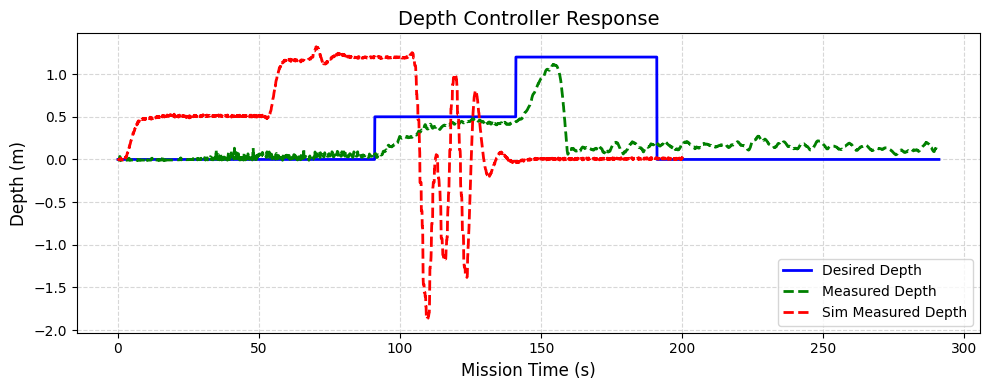

In [216]:

rw_controls_debug = rw_topics["/controls/debug"]

# cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]
cropped_rw_df = rw_controls_debug

sim_controls_debug = sim_topics["/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[sim_crop:end_crop_sim]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["depth.desired"].to_numpy()
y2 = cropped_rw_df["depth.actual"].to_numpy()


# Convert timestamp to seconds since mission start
start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["depth.desired"].to_numpy()
y_sim2 = cropped_sim_df["depth.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Desired Depth', color='blue', linewidth=2)
ax.plot(x, y2, label='Measured Depth', color='green', linewidth=2, linestyle='--')
# # ax.plot(x_sim, y_sim1, label='Depth Sim Desired', color='purple', linewidth=2)

ax.plot(x_sim, y_sim2, label='Sim Measured Depth', color='red', linewidth=2, linestyle='--')


# # ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1079372/1232251447.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()
/tmp/ipykernel_1079372/1232251447.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


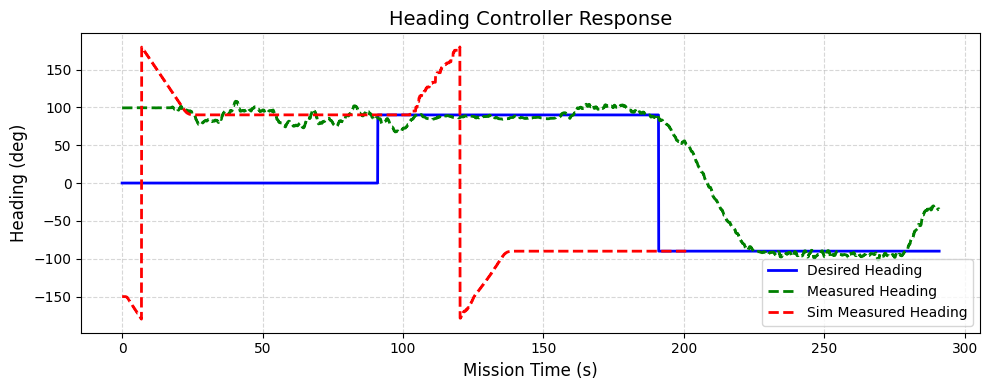

In [217]:

rw_controls_debug = rw_topics["/controls/debug"]
cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]

sim_controls_debug = sim_topics["/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[sim_crop:end_crop_sim]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["heading.desired"].to_numpy()
y2 = cropped_rw_df["heading.actual"].to_numpy()


start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["heading.desired"].to_numpy()
y_sim2 = cropped_sim_df["heading.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Desired Heading', color='blue', linewidth=2)
ax.plot(x, y2, label='Measured Heading', color='green', linewidth=2, linestyle='--')

ax.plot(x_sim, y_sim2, label='Sim Measured Heading', color='red', linewidth=2, linestyle='--')
# ax.plot(x_sim, y_sim1, label='Sim Desired Depth', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


In [218]:
import re
def extract_key_values_regex(status_str):
    try:
        keyvals = {}

        # Regex pattern to extract key-value pairs
        pattern = r"key='([^']*)', value='([^']*)'"
        matches = re.findall(pattern, status_str)

        # Additional context to identify the group like CPU or RAM
        hardware_match = re.search(r"hardware_id='([^']*)'", status_str)
        name_match = re.search(r"name='([^']*)'", status_str)

        hardware_id = hardware_match.group(1) if hardware_match else "unknown"
        name = name_match.group(1).replace(":", "").replace(" ", "_") if name_match else "unknown"

        for key, value in matches:
            full_key = f"{hardware_id}/{name}/{key}"
            try:
                value = float(value)
            except ValueError:
                value = None
            keyvals[full_key] = value

        return keyvals
    except Exception as e:
        return {}
    
def find_matching_key(columns, partial_key):
    for col in columns:
        if partial_key.lower() in col.lower():
            # print(f"Found match for '{partial_key}': '{col}'")
            return col
    raise KeyError(f"No match found for: {partial_key}")



# compare the diagnostics CPU and RAM usage from real world and sim
rw_diagnostics = rw_topics["/diagnostics"]
# cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]

sim_diagnostics = sim_topics["/diagnostics"]
# cropped_sim_df = sim_diagnostics.iloc[sim_crop:end_crop_sim]

# Apply and normalize the extracted values
rw_extracted = rw_diagnostics["status"].apply(extract_key_values_regex)
rw_diagnostics_expanded = pd.json_normalize(rw_extracted)

sim_extracted = sim_diagnostics["status"].apply(extract_key_values_regex)
sim_diagnostics_expanded = pd.json_normalize(sim_extracted)

# print(rw_diagnostics_expanded.columns.tolist())
# print(rw_extracted.iloc[0])

cpu_key_rw = find_matching_key(rw_diagnostics_expanded.columns, "CPU Load Average")
ram_key_rw = find_matching_key(rw_diagnostics_expanded.columns, "RAM Load Average")

cpu_key_sim = find_matching_key(sim_diagnostics_expanded.columns, "CPU Load Average")
ram_key_sim = find_matching_key(sim_diagnostics_expanded.columns, "RAM Load Average")

avg_cpu_usage = rw_diagnostics_expanded[cpu_key_rw].mean()
avg_ram_usage = rw_diagnostics_expanded[ram_key_rw].mean()

avg_cpu_usage_sim = sim_diagnostics_expanded[cpu_key_sim].mean()
avg_ram_usage_sim = sim_diagnostics_expanded[ram_key_sim].mean()

print(f"Average CPU Usage (Real World): {avg_cpu_usage}")
print(f"Average RAM Usage (Real World): {avg_ram_usage}")
print(f"Average CPU Usage (Simulation): {avg_cpu_usage_sim}")
print(f"Average RAM Usage (Simulation): {avg_ram_usage_sim}")

Average CPU Usage (Real World): 51.98852233676976
Average RAM Usage (Real World): 9.299999999999999
Average CPU Usage (Simulation): 30.62641791044776
Average RAM Usage (Simulation): 8.572139303482585
